# Brownian Paths

In [1]:
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import seaborn as sns
import signatory
import torch

from regimedetection.examples.brownianpaths.utils import simulate_gbm_process
from regimedetection.src.clustering import delta_k_t
from regimedetection.src.clustering import get_similarities_matrix
from regimedetection.src.clustering import get_space_distances
from regimedetection.src.clustering import get_space_similarities
from regimedetection.src.clustering import get_transition_matrix_from_similarities_matrix
from regimedetection.src.clustering import multiscale_k_prototypes
from regimedetection.src.kernels import make_rbf_kernel
from regimedetection.src.kernels import make_mmd_estimate_metric_from_kernel
from regimedetection.src.similarities import make_gaussian_similarity
from regimedetection.src.utils.plot import make_colours

### Example Setup

In this context, a **point** is defined to be a collection of logsignatures of Brownian paths. Here, we take a collection of 5 paths, time-augment, and take the logsignature (up to some depth) in order to get a collection of 5 logsignatures which represent the point. In this example, within each point, each path is generated using the same $(\mu, \sigma)$ values.

A **cluster** is, as usual, some collection of *similar* points. Here *similar* is with respect to a metric which has yet to be defined.

In order to simulate clusters, for each of the specified $(\mu, \sigma)$ pairs below, we generate `points_per_cluster * paths_per_point` GBM paths with the specified $\mu$, $\sigma$ values. We plot these first then compute logsignatures.

In [2]:
np.random.seed(0)

In [3]:
# Number of subintervals to divide the interval [0,1] into in the generated paths
N_TIME_STEPS = 100

POINTS_PER_CLUSTER = 5
PATHS_PER_POINT = 10

# The depth at which to truncate the (infinite) logsignature vectors
LOGSIGNATURE_DEPTH = 5

In [4]:
MAX_SUGGESTED_CLUSTERS = 10
MAX_STEPS_POWER = 5

In [5]:
# Metric parameters
RBF_KERNEL_SIGMA = 0.1
GAUSSIAN_SIMILARITY_SIGMA = 0.15

### Generate and Display Example Points

In [6]:
cluster_parameters = (
    (0.15, 0.15),
    (0.15, 0.35),
    (0.05, 0.15),
    (0.05, 0.35)
)

In [7]:
sns.set_style("dark")

In [8]:
n_clusters = len(cluster_parameters)
n_points = n_clusters * POINTS_PER_CLUSTER
n_paths_per_cluster = POINTS_PER_CLUSTER * PATHS_PER_POINT
n_paths = n_points * PATHS_PER_POINT

n_required_colours = max(n_clusters, MAX_SUGGESTED_CLUSTERS)

colours = make_colours(n_required_colours)

For efficiency, we generate a 2-dimensional array of path innovations. Iterative over each cluster $(\mu, \sigma)$ pair, we populate this paths array with the relevant paths. This allows one call to `signatory.logsignature` in order to compute the required signature transforms.

In [9]:
time_steps = np.linspace(0, 1, N_TIME_STEPS)
paths = np.empty(shape=(n_paths, N_TIME_STEPS))

for cluster_idx, (mu, sigma) in enumerate(cluster_parameters):
    cluster_paths = simulate_gbm_process(
        time_steps,
        n_paths_per_cluster,
        mu,
        sigma
    )
    
    cluster_start_idx = cluster_idx * n_paths_per_cluster
    cluster_end_idx = cluster_start_idx + n_paths_per_cluster
    
    paths[cluster_start_idx : cluster_end_idx] = cluster_paths

### Plot a Subset of Generated Paths

In [10]:
PLOTTED_PATHS_PER_CLUSTER = 10

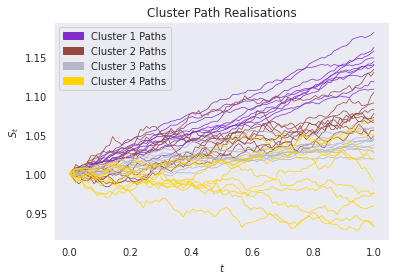

In [11]:
for cluster_number in range(n_clusters):    
    cluster_colour = colours[cluster_number]
    
    cluster_indices = np.arange(
        cluster_number * n_paths_per_cluster,
        (cluster_number + 1) * n_paths_per_cluster
    )
    plotted_cluster_indices = np.random.choice(
        cluster_indices,
        size = PLOTTED_PATHS_PER_CLUSTER,
        replace = False
    )
    plotted_paths = paths[plotted_cluster_indices]
    
    plt.plot(
        time_steps,
        plotted_paths.T,
        color=cluster_colour,
        lw=0.7
    )
    
label_entries = tuple(
    mpatches.Patch(
        color=colours[cluster_number],
        label=f"Cluster {cluster_number+1} Paths"
    )
    for cluster_number in range(n_clusters)
)

plt.legend(handles=label_entries)

plt.title("Cluster Path Realisations")
plt.xlabel("$t$")
plt.ylabel("$S_t$")
plt.show()

### Computing Logsignatures & Defining Points

In [12]:
time_augmented_paths = np.empty(shape=(n_paths, N_TIME_STEPS, 2))
time_augmented_paths[..., 0] = time_steps
time_augmented_paths[..., 1] = paths

In [13]:
logsignatures = signatory.logsignature(
    torch.from_numpy(time_augmented_paths),
    depth=LOGSIGNATURE_DEPTH
).numpy()

The points in our space are collections of these logsignatures

In [14]:
points = np.array(np.split(logsignatures, n_points))

# Clustering

Let's take the *MMD Estimate* metric induced by the [*Radial Basis Function Kernel*](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), given by

$$
K^{\sigma}(x, y) := \exp \left\{ - \frac{\lvert\lvert x - y \rvert\rvert^2}{2\sigma^2} \right\}
$$

In [15]:
# Generates a vectorized RBF Kernel function 
rbf_kernel = make_rbf_kernel(RBF_KERNEL_SIGMA)
mmd_estimate_metric = make_mmd_estimate_metric_from_kernel(rbf_kernel)

gaussian_similarity = make_gaussian_similarity(GAUSSIAN_SIMILARITY_SIGMA)

In [16]:
similarities_matrix = get_similarities_matrix(
    points, mmd_estimate_metric, gaussian_similarity
)

transition_matrix = get_transition_matrix_from_similarities_matrix(
    similarities_matrix
)

### Eigengap Plot

In [17]:
evalues = np.linalg.eig(transition_matrix)[0]

# Sort eigenvalues from largest to smallest
idx = evalues.argsort()[::-1]
evalues = evalues[idx]

In [18]:
# Cluster numbers considered - most general would be {1, ..., N} where
# N = number of points
k_values = np.arange(1, MAX_SUGGESTED_CLUSTERS+1)

# Number of steps considered - could be more clever about this and infer
# from the dataset what the maximum number of steps should be, e.g. by
# checking when the 1-clustering starts to be the recommendation
t_values = np.logspace(start=0, stop=MAX_STEPS_POWER, num=1000)

$\Delta_K(t) = |\lambda_{K}|^t - |\lambda_{K+1}|^t$ for $k \in \{1, 2, \ldots, \textrm{maxSuggestedClusters}\}$, $0 \leq t \leq 10^{\textrm{maxStepsPower}}$

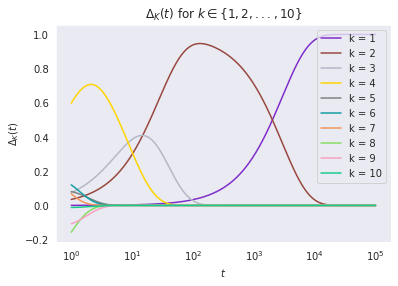

In [19]:
delta_k_t_values = delta_k_t(k_values, t_values, evalues)

for idx, k in enumerate(k_values):
    plt.plot(
        t_values,
        delta_k_t_values[idx],
        label=f"k = {k}",
        color = colours[idx]
    )
    
if len(k_values) <= 5:
    plot_title = "$\Delta_K(t)$ for $k \in \{" + ", ".join(str(x) for x in k_values) + "\}$" 
elif len(k_values) > 5:
    plot_title = "$\Delta_K(t)$ for $k \in \{1, 2, ..., " + str(max(k_values)) + "\}$"
    
plt.xscale("log")
plt.xlabel("$t$")
plt.ylabel("$\Delta_K(t)$")
plt.title(plot_title)
plt.legend()
plt.show()

$\Delta(t) = \max_{K} \Delta_K(t)$ for $0 \leq t \leq 10^{\textrm{maxStepsPower}}$:

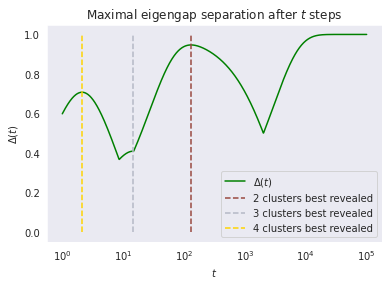

In [20]:
delta_t_values = delta_k_t_values.max(axis=0)

plt.plot(t_values, delta_t_values, label="$\Delta(t)$", color="green")

# Add lines to show local maxima of delta_k_t for appropriate values of k
for idx, t_idx in enumerate(delta_k_t_values.argmax(axis=1)):
    if idx == 0:
        continue
    
    k = k_values[idx]
    t = t_values[t_idx]
    
    if delta_k_t_values[:, t_idx].argmax(axis=0) == idx:
        plt.plot(
            [t, t],
            [0, 1],
            label=f"{k} clusters best revealed",
            color=colours[idx],
            linestyle="dashed"
        )

plt.title("Maximal eigengap separation after $t$ steps")
plt.xlabel("$t$")
plt.ylabel("$\Delta(t)$")

plt.xscale("log")
plt.legend()
plt.show()

Number of clusters best revealed by $t$ steps, $K(t)$:

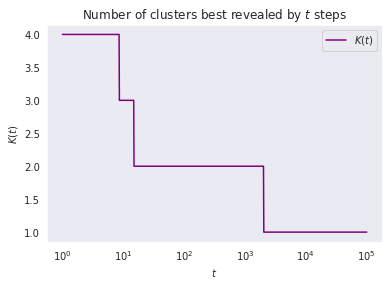

In [21]:
clusters_best_revealed = delta_k_t_values.argmax(axis=0) + 1

plt.plot(t_values, clusters_best_revealed, label="$K(t)$", color="purple")

plt.title("Number of clusters best revealed by $t$ steps")
plt.xlabel("$t$")
plt.ylabel("$K(t)$")

plt.xscale("log")
plt.legend()
plt.show()

In [22]:
suggested_partitions = multiscale_k_prototypes(
    transition_matrix,
    max_steps_power = MAX_STEPS_POWER,
    max_clusters = MAX_SUGGESTED_CLUSTERS
)

In [23]:
PLOTTED_PATHS_PER_SUGGESTED_CLUSTER = 10

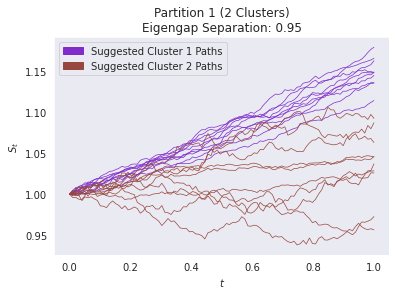

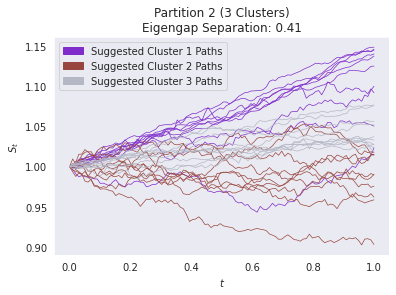

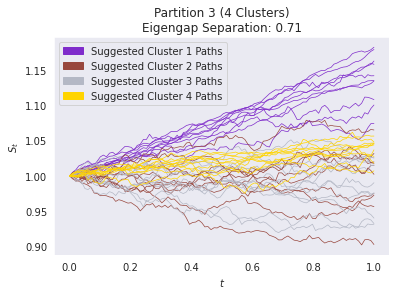

In [24]:
for partition_idx, (partition, partition_suitability) in enumerate(suggested_partitions):
    plot_legend_entries = []
    
    for cluster_idx, cluster_indices in enumerate(partition):
        cluster_colour = colours[cluster_idx]
        
        suggested_cluster_path_indices = np.concatenate(
            tuple(
                np.arange(
                    PATHS_PER_POINT * point_idx,
                    PATHS_PER_POINT * (point_idx + 1)
                )
                for point_idx in cluster_indices
            )
        )
        
        suggested_cluster_paths = paths[suggested_cluster_path_indices]
        plotted_path_indices = np.random.choice(
            len(suggested_cluster_paths),
            size = PLOTTED_PATHS_PER_SUGGESTED_CLUSTER,
            replace = False
        )
        plotted_paths = suggested_cluster_paths[plotted_path_indices]
        
        for path in plotted_paths:
            plt.plot(
                time_steps,
                path,
                color = cluster_colour,
                lw = 0.7
            )
        
        plot_legend_entries.append(
            mpatches.Patch(
                color = cluster_colour,
                label = f"Suggested Cluster {cluster_idx + 1} Paths"
            )
        )
        
    plot_title = f"Partition {partition_idx+1} ({len(partition)} Clusters)"
    plot_title += f"\nEigengap Separation: {round(partition_suitability, 2)}"

    plt.title(plot_title)
    plt.xlabel('$t$')
    plt.ylabel('$S_t$')
    plt.legend(handles=plot_legend_entries)
    plt.show()

Count occurrences of each parameter selection in the suggested clusters

In [25]:
for partition_idx, (partition, suitability) in enumerate(suggested_partitions):
    print(f"Partition {partition_idx+1} ({len(partition)} Clusters)")
    print(f"Partition Suitability: {round(suitability, 2)}")
    print()
    
    for cluster_idx, cluster in enumerate(partition):
        print(f"\tCluster {cluster_idx+1}:\n")
        
        parameter_counts = {str(param): 0 for param in cluster_parameters}
        
        for point_idx in cluster:
            parameter_idx = math.floor(point_idx / POINTS_PER_CLUSTER)
            parameter_string = str(cluster_parameters[parameter_idx])
            parameter_counts[parameter_string] += 1
            
        printed_parameter_counts = {
            param_str: param_count
            for param_str, param_count in parameter_counts.items()
            if param_count > 0
        }
        
        for param_str, param_count in printed_parameter_counts.items():
            print(f"\t\t{param_str}: {param_count}")
        print()
    
    print()

Partition 1 (2 Clusters)
Partition Suitability: 0.95

	Cluster 1:

		(0.15, 0.15): 5

	Cluster 2:

		(0.15, 0.35): 5
		(0.05, 0.15): 5
		(0.05, 0.35): 5


Partition 2 (3 Clusters)
Partition Suitability: 0.41

	Cluster 1:

		(0.15, 0.15): 5
		(0.15, 0.35): 5

	Cluster 2:

		(0.05, 0.35): 4

	Cluster 3:

		(0.05, 0.15): 5
		(0.05, 0.35): 1


Partition 3 (4 Clusters)
Partition Suitability: 0.71

	Cluster 1:

		(0.15, 0.15): 5
		(0.15, 0.35): 5

	Cluster 2:

		(0.05, 0.35): 3

	Cluster 3:

		(0.05, 0.35): 1

	Cluster 4:

		(0.05, 0.15): 5
		(0.05, 0.35): 1


